In [1]:
%load_ext autoreload 

In [2]:
autoreload 2

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
import seaborn as sn

import pycollocation

<h1> Example: Solow model of economic growth</h1>

The Solow model is a model of economic growth as a process of physical capital accumulation. The model reduces down to a single non-linear ordinary differential equation (ODE) and an initial condition...

$$ \dot{k}(t) = s f(k(t)) - (g + n + \delta) k(t),\ k(0) = k_0 $$

...the above equation says that the rate of change of the stock of physical capital (per unit effective labor supply), $\dot{k}(t)$, is the difference between the actual level of investment in physical capital, $sf(k(t))$, and the amount of investment required to maintain the current level of physical capital, $(g + n + \delta) k(t)$.


In [5]:
class SolowModel(pycollocation.IVP):
    """Class representing a Solow growth model."""
    
    def __new__(cls, intensive_output, mpk, params):
        bcs_lower = lambda t, k, k0, **params: [k - k0]
        bcs_lower_jac = lambda t, k, **params: 1.0
        rhs = cls._rhs_factory(intensive_output)
        rhs_jac = cls._rhs_jac_factory(mpk)
        return super(SolowModel, cls).__new__(cls, bcs_lower, 1, 1, params,
                                              rhs, bcs_lower_jac, rhs_jac)    
    @staticmethod
    def _equation_motion_capital(t, k, f, delta, g, n, s, **params):
        return s * f(k, **params) - (g + n + delta) * k
    
    @staticmethod
    def _solow_model_jac(t, k, mpk, delta, g, n, s, **params):
        return s * mpk(k, **params) - (g + n + delta)
    
    @classmethod
    def _rhs_factory(cls, f):
        
        def rhs(t, k, delta, g, n, s, **params):
            return [cls._equation_motion_capital(t, k, f, delta, g, n, s, **params)]
        
        return rhs
    
    @classmethod
    def _rhs_jac_factory(cls, mpk):
        
        def rhs_jac(t, k, delta, g, n, s, **params):
            return [cls._solow_model_jac(t, k, mpk, delta, g, n, s, **params)]
        
        return rhs_jac


In [6]:
def ces_output(k, alpha, sigma, **params):
    rho = (sigma - 1) / sigma
    if rho == 0:
        y = k**alpha
    else:
        y = (alpha * k**rho + (1 - alpha))**(1 / rho)
    return y


def ces_mpk(k, alpha, sigma, **params):
    rho = (sigma - 1) / sigma
    if rho == 0:
        mpk = alpha * k**(alpha - 1)
    else:
        y = ces_output(k, alpha, sigma, **params)
        mpk = alpha * k**(rho - 1) * (y / (alpha * k**rho + (1 - alpha)))
    return mpk

In [7]:
solow_params = {'g': 0.02, 's': 0.1, 'n': 0.02, 'alpha': 0.15, 'sigma': 2.0,
                'delta': 0.04, 'k0': 1.0}

We need to come up with some decent initial guess for the initial coefficients...

In [8]:
def steady_state_capital(g, n, s, alpha, delta, sigma, **params):
    """Steady state value for capital stock (per unit effective labor)."""
    rho = (sigma - 1) / sigma
    if rho == 0:
        kss = (s / (g + n + delta))**(1 / (1 - alpha))
    else:
        kss = ((1 - alpha) / (((g + n + delta) / s)**rho - alpha))**(1 / rho)
    return kss

domain = [0, 100]
kstar = steady_state_capital(**solow_params)
ts = np.linspace(domain[0], domain[1], 1000)
ks = kstar - (kstar - solow_params['k0']) * np.exp(-ts)

initial_poly = np.polynomial.Chebyshev.fit(ts, ks, 15, domain)
initial_coefs = initial_poly.coef


In [9]:
nodes = pycollocation.PolynomialSolver.collocation_nodes(15, domain, "Chebyshev")

In [10]:
solow_model = SolowModel(ces_output, ces_mpk, solow_params)
solution = pycollocation.PolynomialSolver.solve({'kind': 'Chebyshev'},
                                                initial_coefs,
                                                domain,
                                                nodes,
                                                solow_model)

In [11]:
k_hat, = solution.functions

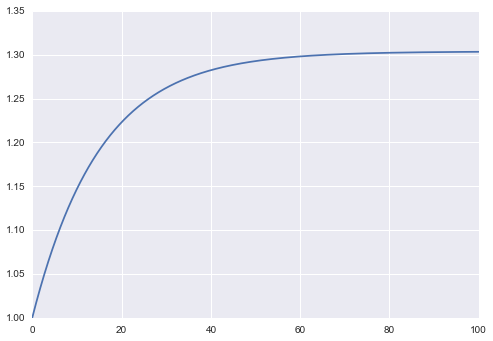

In [12]:
ts = np.linspace(0, 100, 1000)
plt.plot(ts, k_hat(ts))

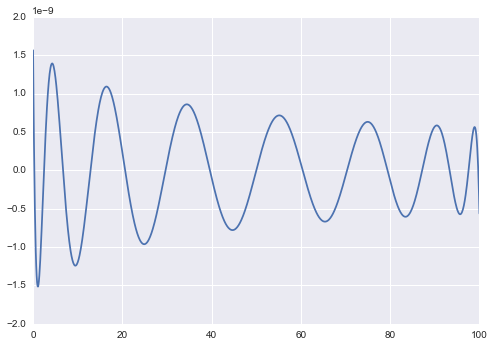

In [13]:
k_resids, = solution.residuals(ts)
plt.plot(ts, k_resids)